<a href="https://colab.research.google.com/github/CosmoStat/Tutorials/blob/tensorflow-tutorial/TensorFlowFirstSteps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 Francois Lanusse, Zaccharie Ramzi

Licensed under the Apache License, Version 2.0 (the "License");


# First steps with TensorFlow

Authors: [@EiffL](https://github.com/EiffL) (Francois Lanusse), [@zaccharieramzi](https://github.com/zaccharieramzi) (Zaccharie Ramzi)

## Overview

In this short notebook, we will review the basics of TensorFlow, how to write a computational graph, compute gradients by automatic differentiation, and perform optimization. This introduction is intended for first time TensorFlow users, and can be safely disregarded by experienced users.  
**Note**: we only consider TensorFlow 2.x here.

### Learning goals

In this notebook, we will learn:
  - Core principles of TensorFlow
  - How to write a computational graph
  - How to compute gradients
  - How to perform optimization

## What is a Tensor?

Let us get started with a minimal example:

In [0]:
import numpy as np
import tensorflow as tf

x = tf.zeros(shape=[8])

This code is pretty much self explanatory, we have defined an object x to be an "array" of zeros of size 8. Let's take a closer look at this object:

In [2]:
x

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

We see that this object is in fact a TensorFlow Tensor, characterized by:
  - A **shape**, e.g. (8,)
  - A **type**, noted as `dtype`, here by default a single precision float i.e. `float32`, but types include `int32`, `float64`, `complex64`, etc.


In addition, we see that this tensor has an associated value, denoted by a numpy array.


A numpy array can be converted into a TensorFlow tensor and vice-versa easily using the `tf.convert_to_tensor` function and `.numpy()` member of Tensor objects:

In [3]:
# Define a numpy array:
x = np.array( [1., 2., 3., 4.])

# Convert it into a tensor:
a = tf.convert_to_tensor( x )

# Inspect Tensor a:
a

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([1., 2., 3., 4.])>

In [4]:
# Convert back this tensor into a numpy array
y = a.numpy()

# Inspect array y:
y

array([1., 2., 3., 4.])

## Defining computational graphs

Now that we have introduced the notion of Tensors, let's learn about the Flow part :-) 

TensorFlow defines computations in terms of simple **operations** (`ops` for short) which can manipulate, create, or destroy tensors. These `ops`can be stringed together into a computational graph in order to perform complex operations.

Let us consider a very simple computation: $y = a * x + b$  
In the general case `y`, `a`, `y`, and `b` are all tensors, and the fundamental `ops` needed here are `add` and `multiply`. Here is how the computational graph would look like:
```
                              a          x
                               \        /
                               [multiply]
                                   |      b         
                                   \     /
                                    [add]
                                      |
                                      y
```
writing this computation in tensorflow is extremely simple:

In [0]:
# Let's introduce the input tensors
a = tf.ones(shape=(4,))
b = tf.zeros(shape=(4,))
x = tf.convert_to_tensor(np.array([1., 2., 3., 4.]), dtype=tf.float32)

# And here we define the computation
y = a * x + b

In [6]:
y

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 2., 3., 4.], dtype=float32)>

Feel free to experiment with the code above, in particular, try changing the shape or dtypes of the input tensors, what happens?

Because TF 2 uses eager execution, everything seems to happen at once, and it is not clear when the graph is created and executed. It is possible to define explicitly a graph that will be executed in one piece, i.e. without costly back and forth between python and GPU code using the `tf.function` decorator. 

Consider this example:

In [0]:
def affine_transform(x, a, b):
  return a * x + b

In [9]:
affine_transform(1 , 2 , 3)

5

This is pure Python code, and returns a Python integer. No TensorFlow is involved here at all.

Now let's add the `@tf.function` decorator and see what happens:

In [0]:
@tf.function
def affine_transform(x, a, b):
  return a * x + b

In [0]:
affine_transform(1 , 2 , 3)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

We see that this function now returns a tensor, despite being provided pure Python integer. The `tf.function` decorator indicates to TensorFlow that this function should be interpreted as a computational graph and executed as such on GPU. When calling the function, the input arguments are automatically transformed to tensors, fed to the graph, and the result is retrieved and returned to Python.



## Computing gradients

The most important part of TensorFlow is **automatic differentation**, this is of course at the heart of deep learning but is also a game changer for many applications.

As we have seen in the previous section, a TensorFlow computation is in fact a graph of operations and tensors. This symbolic representation of the computation allows TensorFlow in particular to compute gradients of tensors with respect to other tensors in the graph, using the **chain rule**.

If $y = a * x + b$ as in the previous example, we can also write it in terms of fundamental `ops` in the form:
$$ y = u + b \qquad u = a * x $$
 then:
$$\frac{\partial y}{\partial x} = \frac{\partial y}{\partial u} \frac{ \partial u}{\partial x} = 1 \times a = a$$  
All we need in order to compute the  gradients of any tensors with respect to any other tensor in the graph, is the expression of the $\frac{\partial f}{\partial x}$ for each `op` $f$, this is exactly what TensorFlow provides!  
Almost all TensorFlow operations have an associated gradient, and can be backpropagated through. This is example was trivial, but in the case of a neural network, there can be hundreds of `ops` in this gradient computation by the chain rule, and it's no problem.


What this means for you is that *you only need to write down the forward model, and you get gradients for free*.

Let's try it out with a simple matrix operation:

In [0]:
# Let's build a random orthogonal matrix
A = np.random.randn(64, 64)
A,_ = np.linalg.qr(A.T.dot(A)) # We make it nice and orthogonal ;-)

# Define a true input vector
x_t = np.zeros(64)
x_t[[16,32]] =1.0

# Compute some observations
y = A.dot(x_t)

Populating the interactive namespace from numpy and matplotlib


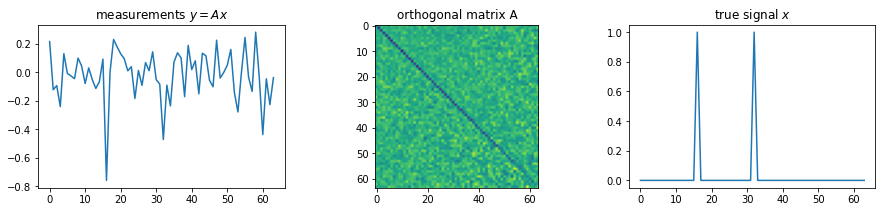

In [119]:
#@title Plotting

%pylab inline
figure(figsize=(15,3))
subplot(131)
plot(y)
title(r'measurements $y = A x$')
subplot(132)
imshow(A)
title(r'orthogonal matrix A')
subplot(133)
plot(x_t)
title(r'true signal $x$');

This situation typically arises when trying to solve inverse problems, which involves computing an $\ell_2$ data fidelity term of the form:

$$ l = \frac{1}{2} \parallel y - A x \parallel_2^2 $$

and then try to optimize the value of $x$ as to minimize this loss. For  this, we need the gradients $\frac{\partial l}{\partial x}$. Classically, this would have to be computed by hand, and we would obtain analytically that:

$$ \frac{\partial l}{\partial x} = A^t (y - A x) $$

One would then have to write down this expression in numpy:

In [0]:
def loss(x, y, A):
  return 0.5 * np.sum( (y - A.dot(x))**2 )

def grad_loss(x, y, A):
  return - A.T.dot(y - A.dot(x))

# Let's define a first random guess solution x
x = 0.5*np.random.randn(64)
l = loss(x, y, A)
dl_dx = grad_loss(x, y, A)

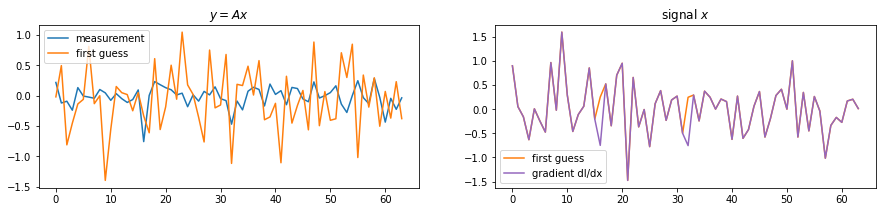

In [121]:
#@title Plotting

figure(figsize=(15,3))
subplot(121)
plot(y, label='measurement')
plot(A.dot(x), label='first guess')
title(r'$y = A x$')
legend()
subplot(122)
plot(x, label='first guess', color='C1')
plot(dl_dx, label='gradient dl/dx', color='C4')
title(r'signal $x$');
legend();

The left plot shows the true measurements $y$ in blue, and the predicted value of $y$ given our current first guess of $x$. All we see here is that the prediction does not match the data.

On the right plot, we see in orange the current first guess for $x$, and we overlay in purple the gradient of $l$ with respect to $x$. 

Can you guess why the gradient almost completely overlaps with the first guess? Hint: the matrix $A$ is orthogonal ;-)

To do the same thing in TensorFlow, let's begin by defining the $\ell_2$ loss as a TensorFlow function: 

In [0]:
# Now, let's try to do the same thing in tensorflow
@tf.function
def loss(x, y, A):
  return 0.5 * tf.reduce_sum( (y - tf.linalg.matvec(A, x))**2 )

# Define a TF tensor using the numpy guess
x_tf = tf.convert_to_tensor(x)

In order to compute the gradient of this loss, in TF 2.0 we use a so-called **Gradient Tape**. As the name sort of implies, this "tape" is used to record all of the `ops` that occur when computing a function, and this trace can be later used to figure out gradients.

Concretely, the **GradientTape** is a Python context inside which you can execute some tensorflow code:

In [123]:
with tf.GradientTape() as g:
  # Tell TF to keep and eye on this tensor
  g.watch(x_tf)
  # Compute the loss
  l_tf = loss(x_tf, y, A)

# Request gradient with respect to x
dl_dx_tf = g.gradient(l_tf, x_tf)

print("Loss computed by numpy: %0.5f ; loss computed by tensorflow: %0.5f"%(l, l_tf))

Loss computed by numpy: 9.04372 ; loss computed by tensorflow: 9.04372


We can now compare manual Python gradients with the TensorFlow ones:

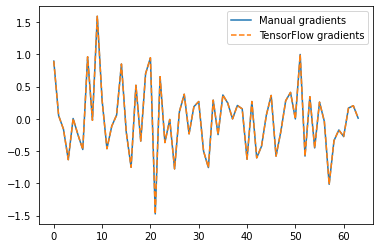

In [124]:
plot(dl_dx, label='Manual gradients');
plot(dl_dx_tf, label='TensorFlow gradients', ls='--');
legend();
assert np.allclose(dl_dx, dl_dx_tf)

## Optimization

Now that we know how to compute gradients, we can use them for solving problems by gradient descent. We will try to solve problems of the form:
$$\min_x \parallel y - A x \parallel_2^2 $$

Here we introduce the notion of TensorFlow **variables**. A variable, contrary to a regular tensor, stores a persistent value in the graph and can be updated using `.assign()`. Typically, variables will be used for the part of the graph you want to optimize.

Let us start by initializing a variable to store the solution of our inverse problem:

In [0]:
# Initizalize a variable, set to 0, and marked as trainable
x_var = tf.Variable(np.zeros(64), trainable=True, name='x')

Similarly to the previous section, we will use a gradient tape to compute the gradient of the loss with respect to that variable. *Note* that the GradientTape will automatically keep track of variables, no need to say `g.watch(x_var)`:

In [0]:
with tf.GradientTape() as g:
  # Compute the loss
  l = loss(x_var, y, A)
  
# Get the gradients
dl_dx = g.gradient(l, x_var)

# We can update the value of the variable like so
x_var.assign_sub(dl_dx); # This one step of gradient descent

Because our matrix A was orthogonal and we don't have any noise, with a single step of gradient descent we recover the solution:

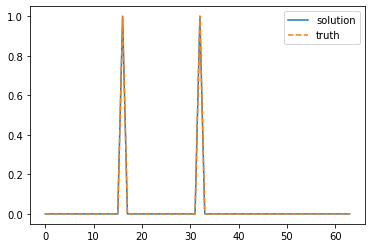

In [127]:
plot(x_var.numpy(), label='solution');
plot(x_t, label='truth', ls='--');
legend();

Now, as an exercise, we will add some noise to the measurement, write an iterative algorithm to solve the problem:

In [0]:
# Create a noisy version of measurements
y = A.dot(x_t) + 0.1*np.random.randn(64)

In [0]:
# Number of iterations
niter = 10

# Initialize variable for solution
x_var = tf.Variable(np.zeros(64), trainable=True, name='x')

@tf.function
def gradient_step(x, y, A):
  with tf.GradientTape() as g:
    g.watch(x)
    l = loss(x_var, y, A)
  dl_dx = g.gradient(l, x)
  return l, dl_dx

for i in range(niter):
  l, dl_dx = gradient_step(x_var, y, A)
  x_var.assign_sub(dl_dx); 

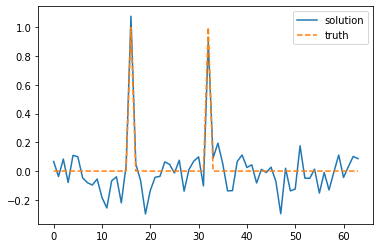

In [156]:
plot(x_var.numpy(), label='solution');
plot(x_t, label='truth', ls='--');
legend();

Because optimizers can get complicated and keeping track of all variables tedious, instead of doing things manually, it's often a great idea to use TensorFlow optimizers, which are typically used for neural networks.

Optimizers have a `minimize` function, which takes as an input a function that return the loss function, and a list of variables to optimize over. One  call to `minimize` performs one iteration of the corresponding algorithm

In [159]:
# Initialize variable for solution
x_var = tf.Variable(np.zeros(64), trainable=True, name='x')

# Define an optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1)

# Perform one iteration of the optimizer
optimizer.minimize( lambda : loss(x_var, y, A), [x_var])

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

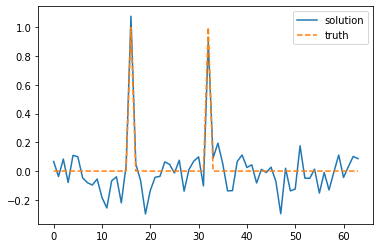

In [161]:
plot(x_var.numpy(), label='solution');
plot(x_t, label='truth', ls='--');
legend();

## Conclusion

This should cover most of the fundamentals of TensorFlow. Here are a few links for reference, and to go further:

  - API reference: https://www.tensorflow.org/api_docs/python/tf
  - Tutorials: https://www.tensorflow.org/tutorials
 
